### Pulse compression concept

Populating the interactive namespace from numpy and matplotlib


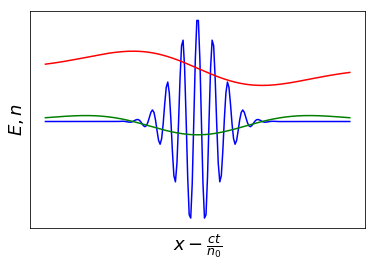

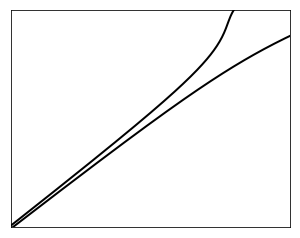

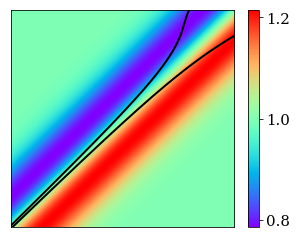

In [1]:
%pylab inline

import numpy as np
import sympy as sp

figsize(6,4)

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'st-pulse-shaping')
file_ext = '.eps'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

font = {'family':'serif', 'weight':'normal', 'size':15}
matplotlib.rc('font', **font)


N = 200
X = 1
k = 2.0*np.pi/X
f_m = 2

x = np.linspace(-5*X, 5*X, N)
E = 2*np.exp(-x**2)*np.cos(2*np.pi*f_m*x)

x_sym = sp.Symbol('x')
n_sym = 1 - 0.25*x_sym*sp.exp(-x_sym**2/3**2)
#n_sym = 1 + 0.25*sp.exp(-x_sym**2)
dn_sym = sp.diff(n_sym)
n_func = sp.lambdify(x_sym, n_sym, modules="numpy")
dn_func = sp.lambdify(x_sym, dn_sym, modules="numpy")

#n = 1.0 + 0.25*x*np.exp(-x**2/2**2)
n = n_func(x)
dn = dn_func(x)

plot(x, E, 'b', label=r'$E$')
plot(x, n, 'r', label=r'$n$')
plot(x, dn, 'g', label=r'$dn/dt$')

xlabel(r'$x-\frac{ct}{n_0}$', fontsize=18)
ylabel(r'$E, n$', fontsize=18)

xticks([])
yticks([])

#legend()

savefig(os.path.join(dir_name, 'st-pulse-compression-concept'+file_ext), bbox_inches='tight', pad_inches=0.0)


show()

##----  ST diagram
figsize(5,4)

c = 1.0
T = X/c
Nx = N
Nt = N
x = np.linspace(0, 5*X, Nx)
t = np.linspace(0, 5*T, Nt)

x_mesh, t_mesh = np.meshgrid(x, t, indexing='ij')

E = np.zeros((Nt, Nx))
n = np.zeros((Nt, Nx))

x_wp = np.zeros(Nt)
x_wm = np.zeros(Nt)

for i in range(Nt):
    t_i = t[i] #+ T/2
    t_i = t[Nt-1-i] #+ T/2
    w = 1.0/(1 + 0.5*t_i + t_i**2)
    a = (1+0.5*t_i)
    t_i = t[i] #+ T/2
    x_wp[i] = c*t_i + w
    x_wm[i] = c*t_i - w
    E[i,:] = 2*a*np.exp(-(x-c*t_i)**2/w**2)
    n[i,:] = 1.0 + 0.5*(x-c*t_i)*np.exp(-(x-c*t_i)**2/1**2)

#pcolor(x_mesh, t_mesh, E, cmap='rainbow')
plot(x_wp, t, 'k', lw=2)
plot(x_wm, t, 'k', lw=2)

xlim(np.min(x), np.max(x))
ylim(np.min(t), np.max(t))

xticks([])
yticks([])

savefig(os.path.join(dir_name, 'st-pulse-compression-concept-minkowski-E'+file_ext), bbox_inches='tight', pad_inches=0.5)
show()

#pcolor(x_mesh, t_mesh, n.T, cmap='rainbow')
imshow(n, cmap='rainbow', vmin=np.min(n), vmax=np.max(n),
           extent=[x.min(), x.max(), t.min(), t.max()],
           interpolation='bicubic', origin='lower', aspect='auto')
colorbar(ticks=[0.8, 1.0, 1.2])

plot(x_wp, t, 'k', lw=2)
plot(x_wm, t, 'k', lw=2)


xlim(np.min(x), np.max(x))
ylim(np.min(t), np.max(t))

xticks([])
yticks([])

savefig(os.path.join(dir_name, 'st-pulse-compression-concept-minkowski-n'+file_ext), bbox_inches='tight', pad_inches=0.0)
show()

 

### FDTD

Populating the interactive namespace from numpy and matplotlib
del_eps: 0.06040000000000001
r0: [ 0.] r1: [ 251.32741229]
r_T_1d: [ 241.90263433] r_R_1d: [ 9.42477796]
simulation time: 0:17


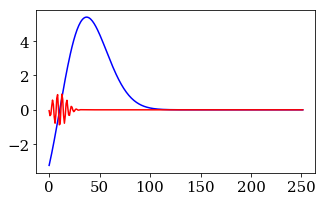

In [26]:
%pylab tk

from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'st-pulse-shaping')
file_ext = '.eps'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)


n_dim = 1
r0, r1, dr = [None]*3
S = 0.8
n_t = None
save_every = 1
source_at_right = False

r_c = None
r0_eps, r1_eps = None, None
r0_deps, r1_deps = None, None
a_eps, b_eps = None, None
omega = 1.0 #2.0*np.pi
omega_ref = omega
s_pml = None
d_pml = None
set_pml = True
is_t_var = True

n0 = 1.5
n1 = 1.52
del_eps = n1**2 - n0**2


L_0 = 2.0*np.pi/(omega_ref*n0)
L_1 = 2.0*np.pi/(omega_ref*n1)



if n_dim==1:
    r0 = np.array([0.0])
    r1 = np.array([60.0*L_0])
    dr = np.array([L_0/100])
    S /= np.sqrt(1)
    n_t = 8000
    if source_at_right:
        n_t = 3000

    d_pml = np.array([2.0*L_0])
    s_pml = np.array([1.0+2.5j/L_0])

    r_c = (r0+r1)/2.0
    a_eps, b_eps = n0**2, n1**2
        
    W_slab = r1-r0-3*d_pml
    r0_deps = r_c - W_slab/2
    r1_deps = r_c + W_slab/2
    
    r0_eps = r0.copy()
    r1_eps = r1.copy()

else:
    assert False
    
dt = S*dr[0]*(min(n0,n1))
d_v = np.prod(dr)

dt_dr = dt/dr[0]

fdtd = FDTDSimulator()

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

d_x_ = np.zeros(n_dim)
d_x_[0] = (r1[0]-r0[0])
d_x_pml = np.zeros(n_dim)
d_x_pml[0] = d_pml[0]


##----- sources

omega_m = 2.0
T_per = 2.0*np.pi/omega
T_0 = 1.0*T_per
t0 = 8.0*T_0
f_t = lambda t: -1.0*np.exp(-(t-t0)**2/(T_0)**2)*np.cos(omega_m*t)           ## 0.1*T_0 for narrow pulse, T_0 for wide
f_t_dt = lambda t: f_t(t-dr[0]/2*n0)

## J
r_j = (r0_deps + d_pml)/2
if source_at_right:
    r_j = (r1_deps + (r1-d_pml))/2

r_j -= r_j - int(r_j/dr[0])*dr[0]
je_mag = 1.0/dr[0]*n0
src_dir = 'z'
je_type = FVTypes.JePoint
je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

## M
r_m = r_j - dr[0]/2      
jm_mag = -1.0/dr[0]
if source_at_right:
    r_m = r_j + dr[0]/2
    jm_mag = 1.0/dr[0]

src_dir = 'y'
jm_type = FVTypes.JmPoint
jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':a_eps}
fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

##---- st pulse medium

Tm_0 = 4.0*T_0
f_t_medium = lambda t: -0.5*np.exp(-(t-t0)**2/Tm_0**2)*(t-t0)    ## -:compressor  +:expander

_x = np.linspace(r0[0], r1[0], 300)
plot(_x, f_t_medium(t0-(_x-r_j[0])/n0), 'b')
plot(_x, f_t(t0-(_x-r_j[0])/n0), 'r')
show()

deps = None
f_deps = None
deps_out = []
if is_t_var:
    print('del_eps:', del_eps)
    a_deps = None
    if n_dim==1:
        a_deps = lambda r, t: del_eps*f_t_medium(t - (r-r_j[0])*n0)
    deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})
    
if set_pml:
    pml_args = {'d_pml':d_pml, 's_pml':s_pml}
    fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

set_Efields_entire_out = True
set_eps_out = True
set_j_out = False
set_T_1d = True
set_R_1d = True


r_R_1d = 0.25*r0_deps + 0.75*(r0+d_pml)
r_T_1d = 0.25*r1_deps + 0.75*(r1-d_pml)
if source_at_right:
    r_T_1d = 0.25*r0_deps + 0.75*(r0+d_pml)
    r_R_1d = 0.25*r1_deps + 0.75*(r1-d_pml)

print('r0:', r0, 'r1:', r1)
print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

if set_Efields_entire_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
if set_j_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
if n_dim==1 and set_T_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
if n_dim==1 and set_R_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})
        
if is_t_var and set_eps_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
    


In [27]:
import matplotlib.pyplot as plt

r_E, E_out_list = None, None
x_E, y_E, z_E = [None]*3
e_max = None
if set_Efields_entire_out:
    r_E, E_out_list = fdtd.GetOutputs('E')
    if n_dim==3:
        x_E, y_E, z_E = r_E
    elif n_dim==2:
        x_E, y_E = r_E
    elif n_dim==1:
        x_E = r_E[0]
    e_max = [np.max(np.abs(e)) for e in E_out_list]
    print('max(e_max):', max(e_max))
    e_max = max(e_max)
    
x_J, y_J, z_J = [None]*3
j_max = None
J_out_list = None
if set_j_out:
    r_J, J_out_list = fdtd.GetOutputs('J')
    if n_dim==3:
        x_J, y_J, z_J = r_J
    elif n_dim==2:
        x_J, y_J = r_J
    elif n_dim==1:
        x_J = r_J[0]
    j_max = [np.max(np.abs(j)) for j in J_out_list]
    print('max(j_max):', max(j_max))
    j_max = max(j_max)



x_deps, y_deps, z_deps = [None]*3
deps_out_list = None
deps_max = None
if is_t_var and set_eps_out:
    r_deps, deps_out_list = fdtd.GetOutputs('Eps')
    if n_dim==3:
        x_deps, y_deps, z_deps = r_deps
    elif n_dim==2:
        x_deps, y_deps = r_deps
    elif n_dim==1:
        x_deps = r_deps[0]
    deps_max = [np.max(np.abs(de)) for de in deps_out_list]
    print('max(deps_max):', max(deps_max))
    deps_max = max(deps_max)


x_T = None
T_arr = None
if n_dim==1 and set_T_1d:
    r_T, T_out_list = fdtd.GetOutputs('T')
    x_T = r_T[0]
    T_arr = np.array([t[0] for t in T_out_list])
    T_max = np.max(np.abs(T_arr))
    print('max(T):', T_max)
    
x_R = None
R_arr = None
if n_dim==1 and set_R_1d:
    r_R, R_out_list = fdtd.GetOutputs('R')
    x_R = r_R[0]
    R_arr = np.array([t[0] for t in R_out_list])
    R_max = np.max(np.abs(R_arr))
    print('max(R):', R_max)
    
    
#print(x_E.shape, E_out_list[0].shape)


max(e_max): 7.20328073537
max(deps_max): 0.325525148763
max(T): 6.32472265816
max(R): 0.00898109860712


In [9]:
## animations
%pylab tk

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib


# Set up formatting for the movie files
#Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
#writer = Writer(fps=15, metadata=dict(artist='Me'))
#writer = animation.FFMpegWriter()

plt.rcParams["figure.figsize"] = (8, 5)

plt_field = 'E'
save_anim = False
file_format = 'mp4'   ## 'gif' / 'mp4'

logscale=False
log_0 = np.log(e_max)-10

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

if set_T_1d:
    T_inc = f_t(np.arange(len(T_arr))*dt*save_every)
    T_inc_fft = np.fft.fft(T_inc)
    T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)
    
    
    print('set_T_1d:', set_T_1d)
    plt.figure()
    plt.plot(np.arange(len(T_arr))*dt*save_every/(2.0*np.pi/omega), T_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Transmission')
    plt.savefig(os.path.join(dir_name, 'T' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    np.savez(os.path.join(dir_name, 'T'), T_arr=T_arr)

    T_fft = np.fft.fft(T_arr)
    T_fft = np.abs(T_fft)/len(T_fft)
    freq = np.fft.fftfreq(T_fft.shape[-1], dt*save_every)

    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    ind_max = np.argmax(np.abs(T_fft))
    x_max = abs(2.0*np.pi*freq[ind_max]/omega_ref)
    print(x_max)
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega_ref, T_fft/T_inc_fft[ind], 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$T(\omega)/T_{inc}(\omega_0)$')
    plt.title('$n_0={}, n_1={}, D/\lambda_0={:.3}, \omega_T/\omega_0={:.3} $'.format(n0, n1, (r1_deps-r0_deps)[0]/L_0, x_max))
    plt.xlim(0.0, 5)
    #plt.ylim([-10.0, 1.0])
    plt.axvline(x=x_max, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'T-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

if set_R_1d:
    print('set_R_1d:', set_R_1d)

    T_inc = f_t(np.arange(len(R_arr))*dt*save_every)
    T_inc_fft = np.fft.fft(T_inc)
    T_inc_fft = np.abs(T_inc_fft)/len(T_inc_fft)
    
    plt.figure()
    plt.plot(np.arange(len(R_arr))*dt*save_every/(2.0*np.pi/omega), R_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Reflection')
    plt.savefig(os.path.join(dir_name, 'R' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

    np.savez(os.path.join(dir_name, 'R'), R_arr=R_arr)
    
    R_fft = np.fft.fft(R_arr)
    R_fft = np.abs(R_fft)/len(R_fft)
    freq = np.fft.fftfreq(R_fft.shape[-1], dt*save_every)

    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega_ref, R_fft/T_inc_fft[ind], 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$R(\omega)/T_{inc}(\omega_0)$')
    plt.xlim(0.0, 5)
    #plt.ylim([-20.0, 20.0])
    plt.axvline(x=1, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'R-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

fig, axarr = None, None
e_max = 1.0
def animate_E(i):
    global e_max
    if not is_t_var:
        plt.clf()
        fig = plt.plot(x_E, E_out_list[i])
        axes = plt.gca()
        axes.set_ylim([-e_max, e_max])
        return fig
    else:
        if not use_subplots:
            plt.clf()
            fig = None
            if plt_field=='E':
                fig = plt.plot(x_E/L_0, E_out_list[i])
                ax = plt.gca()
                e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/2.0)*2.0 + 1.5)
                ax.set_ylim([-e_max, e_max])
                #ax.set_ylim([-2.0, 2.0])
                #ax.axes.get_xaxis().set_ticks([])
                #ax.axes.get_yaxis().set_ticks([])
                
                plt.plot(x_deps/L_0, 2*deps_out_list[i], 'r', lw=0.5)
                
            elif plt_field=='Eps':
                fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                ax = plt.gca()
                ax.set_ylim([-deps_max, deps_max])
                ax.axes.get_xaxis().set_ticks([])
            #fig.set_tight_layout(True)
            plt.xlabel(r'$z/\lambda_0$')
            plt.ylabel(r'$E(t)$')
            plt.title('$n_0={}, M={:.3}, D/\lambda_0={:.3} $'.format(n0, abs(n1-n0)/n0, (r1_deps-r0_deps)[0]/L_0))
            ax = plt.gca()
            ax.set_adjustable('box-forced')
            #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)
            
            plt.axvline(x=(r0+d_pml)[0]/L_0, linewidth=1.0, linestyle='-.',color='r')
            plt.axvline(x=(r1-d_pml)[0]/L_0, linewidth=1.0, linestyle='-.',color='r')
            
            #plt.tight_layout(pad=0.0)
                        
            plt.plot([r_R_1d[0]/L_0], [0], marker='o', color='r')
            plt.plot([r_T_1d[0]/L_0], [0], marker='o', color='r')
            
            return fig
        else:
            plt.clf()
            fig, axarr = plt.subplots(2, sharex=True)
            axarr[0].plot(x_E, E_out_list[i])
            axarr[0].set_ylim([-e_max, e_max])
            axarr[1].plot(x_deps, deps_out_list[i], 'r')
            axarr[1].set_ylim([-deps_max, deps_max])
            return fig


def animate_J(i):
    plt.clf()
    fig = plt.plot(x_J, J_out_list[i])
    axes = plt.gca()
    axes.set_ylim([-j_max, j_max])
    return fig

anim = None
if is_t_var and use_subplots:
    fig, axarr = plt.subplots(2, sharex=True)
else:
    fig = plt.figure()

if plt_field=='E' or plt_field=='Eps':
    anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
elif plt_field=='J':
    anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
else:
    raise ValuError()

if save_anim:
    if file_format=='gif':
        anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
    elif file_format=='mp4':
        anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=15, dpi=200)
plt.show()
    
    


Populating the interactive namespace from numpy and matplotlib
set_T_1d: True
6.25
set_R_1d: True


Populating the interactive namespace from numpy and matplotlib


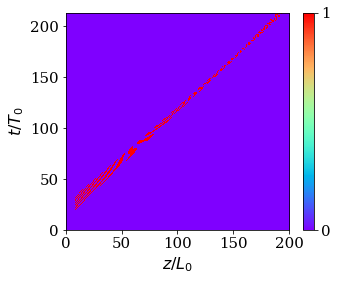

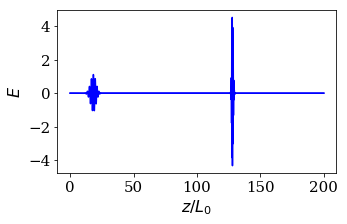

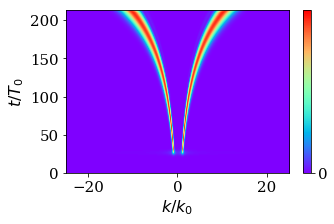

In [28]:
%pylab inline

font = {'family':'serif', 'weight':'normal', 'size':15}
matplotlib.rc('font', **font)

figsize(5, 4)

t_vec = np.linspace(0.0, n_t*dt, n_saved)
x_mesh, t_mesh = np.meshgrid(x_E/L_0/.3, t_vec/T_0/.3, indexing='ij')
E_mesh = np.zeros(x_mesh.shape)

for i in range(n_saved):
    E_mesh[:, i] = E_out_list[i]

"""
for i in range(n_saved):
    if np.max(E_mesh[:, i])>1.0:
        E_mesh[:, i] = (E_mesh[:, i]>np.max(E_mesh[:, i])/10)
"""

E_mesh = E_mesh>0.01

#plt.pcolor(x_mesh, t_mesh, E_mesh)
plt.imshow(E_mesh.T, cmap='rainbow', vmin=np.min(E_mesh), vmax=np.max(E_mesh),
           extent=[x_mesh.min(), x_mesh.max(), t_mesh.min(), t_mesh.max()],
           #interpolation='nearest', 
           origin='lower', aspect='auto')
plt.colorbar(ticks=[0, 1])

xlabel('$z/L_0$', fontsize=16)
ylabel('$t/T_0$', fontsize=16)

file_ext = ".eps"
savefig(os.path.join(dir_name, 'st-pulse-compression-fdtd-st'+file_ext), bbox_inches='tight', pad_inches=0.0)

show()


figsize(5, 3)

ind_0 = int(11*T_0/(dt*save_every))
plot(x_E/L_0/.3, E_out_list[ind_0], 'b')
#yticks([0, 1])
#xlabel('$z/L_0$', fontsize=16)
#ylabel('$E$', fontsize=16)
#savefig(os.path.join(dir_name, 'st-pulse-compression-fdtd-t-0'+file_ext), bbox_inches='tight', pad_inches=0.0)
#show()

ind_1 = -int(20*T_0/(dt*save_every))
plot(x_E/L_0/.3, E_out_list[ind_1], 'b')
xlabel('$z/L_0$', fontsize=16)
ylabel('$E$', fontsize=16)
savefig(os.path.join(dir_name, 'st-pulse-compression-fdtd-t-1'+file_ext), bbox_inches='tight', pad_inches=0.0)
show()


##-------------------------   spectrum
import Electromagnetics.PWE as pwe

E_f_mesh = np.zeros(x_mesh.shape, dtype=complex)
kx_ = np.zeros(x_E.shape)

for i in range(n_saved):
    kx_, E_f_mesh[:, i] = pwe.Fourier1D(x_E, E_out_list[i])


kx_ *= 2.0*np.pi
k_0 = omega_m*n0
E_f_mesh = np.abs(E_f_mesh)
k_mesh, t_mesh = np.meshgrid(kx_/k_0, t_vec/T_0/.3, indexing='ij')


#plt.pcolor(x_mesh, t_mesh, E_mesh)
plt.imshow(E_f_mesh.T, cmap='rainbow', vmin=np.min(E_f_mesh), vmax=np.max(E_f_mesh),
           extent=[(kx_/k_0).min(), (kx_/k_0).max(), t_mesh.min(), t_mesh.max()],
           interpolation='bicubic', 
           origin='lower', aspect='auto')
plt.colorbar(ticks=[0, 1])

xlabel('$k/k_0$', fontsize=16)
ylabel('$t/T_0$', fontsize=16)

file_ext = ".eps"
savefig(os.path.join(dir_name, 'st-modpulse-compression-fdtd-spectrum'+file_ext), bbox_inches='tight', pad_inches=0.0)

show()



### Realization

Populating the interactive namespace from numpy and matplotlib


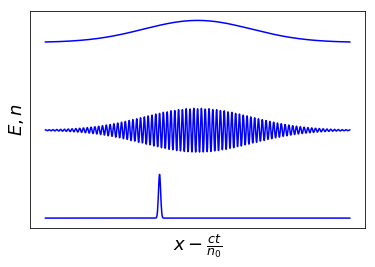

In [45]:
%pylab inline

import numpy as np
import sympy as sp

figsize(6,4)

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'st-pulse-shaping')
file_ext = '.eps'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

font = {'family':'serif', 'weight':'normal', 'size':15}
matplotlib.rc('font', **font)


N = 1000
X = 1
k = 2.0*np.pi/X

x = np.linspace(-20*X, 20*X, N)
E_sig = 2*np.exp(-(x+5)**2/(0.2**2))
E_mod = np.exp(-x**2/10**2)*np.cos(2*np.pi*f_m*x)
E_mod_abs = np.exp(-x**2/10**2)

delta = 4
plot(x, E_sig, 'b')
plot(x, E_mod + delta, 'b')
plot(x, E_mod_abs + 2*delta, 'b')

xlabel(r'$x-\frac{ct}{n_0}$', fontsize=18)
ylabel(r'$E, n$', fontsize=18)

xticks([])
yticks([])

#legend()

savefig(os.path.join(dir_name, 'st-pulse-compression-realization'+file_ext), bbox_inches='tight', pad_inches=0.0)


show()
